This notebook is made to find out a fair train/test subset split based on several factors:
- class weights
- unbiased pixels


# Region selection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
from rasterio import rasterio
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

from skimage.draw import polygon


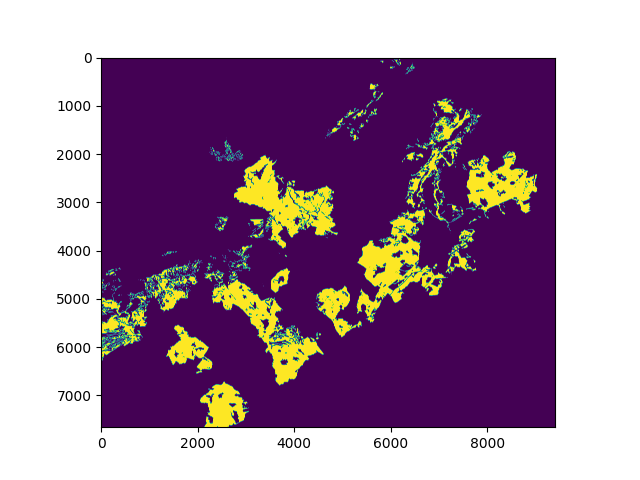

In [6]:
%matplotlib widget


# Verify the image path
image_path = "../data/dataset/binary_mask.png"
if not os.path.exists(image_path):
    print("Image path is incorrect.")
else:
    # Load the image
    img = plt.imread(image_path)

    # Define the region of interest
    up, down, left, right = 3321, 10979, 0, 9401
    image = img[up:down+1, left:right+1]

    # Create a figure and axis
    fig, ax = plt.subplots()
    ax.imshow(image)

    # List to store vertices
    vertices = []

    # Function to handle mouse clicks
    def onclick(event):
        if event.button == 1:  # Left mouse button
            if event.xdata is not None and event.ydata is not None:  # Ensure click is within the image
                vertices.append((event.xdata, event.ydata))  # Fixed typo here
                ax.plot(event.xdata, event.ydata, 'ro', markersize=2)  # Plot red dot
                if len(vertices) > 1:
                    x, y = zip(*vertices)
                    ax.plot(x, y, 'b-')  # Draw blue line between points
                fig.canvas.flush_events()  # Redraw canvas

    # Function to handle key presses
    def onkey(event):
        if event.key == 'enter':  # Enter key
            if len(vertices) > 2:
                print("Polygon vertices:", vertices)
            fig.canvas.flush_events()  # Redraw canvas

    # Connect the event handlers
    cid_click = fig.canvas.mpl_connect('button_press_event', onclick)
    cid_key = fig.canvas.mpl_connect('key_press_event', onkey)

    # Display the plot
    plt.show()


In [ ]:
%matplotlib inline
plt.clf()
binary_mask = image


In [9]:
v = [(int(x), int(y)) for (x,y) in vertices]
v.insert(0, (0, v[0][1]))
v.insert(len(vertices)+1, (0, v[-1][1]))
v

[(0, 854),
 (3226, 854),
 (3039, 2077),
 (2086, 3382),
 (2127, 4190),
 (1982, 4874),
 (3329, 7651),
 (0, 7651)]

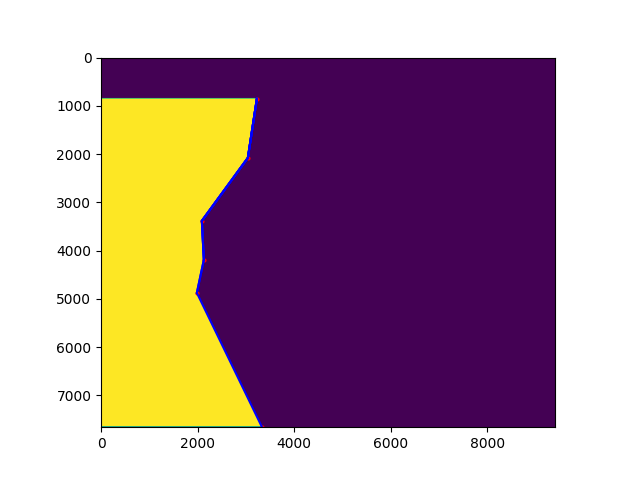

In [10]:
poly_coords = v
poly_rows = [pt[1] for pt in poly_coords]
poly_cols = [pt[0] for pt in poly_coords]
poly_mask = np.zeros(binary_mask.shape, dtype=bool)
rr, cc = polygon(poly_rows, poly_cols, shape=binary_mask.shape)
poly_mask[rr, cc] = True
plt.imshow(poly_mask)
plt.show()

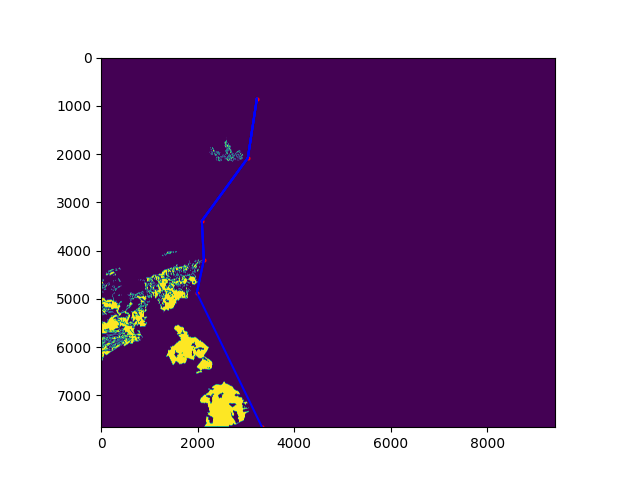

In [11]:
selection = (binary_mask == True) & poly_mask
plt.imshow(selection)
plt.show()

In [12]:
all_valid_pixels = np.sum(binary_mask==True)
region_valid_pixels = np.sum(selection)
print(f"Selected region contains {region_valid_pixels/all_valid_pixels*100:.2f}% of valid pixels")

Selected region contains 20.64% of valid pixels


# Computing class shares

In [13]:
classes = ["Very limited", "Limited", "Average", "High", "Very high"]


In [14]:
label_id = "vit"
label_path = f"../data/dataset/{label_id}_potential.tif"
label = rasterio.open(label_path).read()
label = np.argmax(label, axis=0)
up, down, left, right = 3321, 10979, 0, 9401
label = label[up:down+1, left:right+1]

In [15]:
valid_pixels = label[binary_mask==True]
_, counts = np.unique(valid_pixels, return_counts=True)
total = sum(counts)
shares = [c / total for c in counts]
print(f"Full set, label type: {label_id}")
for i in range(len(classes)):
    print(f"Class '{classes[i]}': {shares[i]*100:.2f}%")
print(f"[Safety check] Total: {np.sum(shares)*100:.2f}%")

Full set, label type: vit
Class 'Very limited': 24.68%
Class 'Limited': 19.21%
Class 'Average': 22.64%
Class 'High': 17.26%
Class 'Very high': 16.21%
[Safety check] Total: 100.00%


In [16]:
subset_pixels = label[selection]
_, counts = np.unique(subset_pixels, return_counts=True)
total = sum(counts)
shares = [c / total for c in counts]
print(f"Subset, label type: {label_id}")
for i in range(len(classes)):
    print(f"Class '{classes[i]}': {shares[i]*100:.2f}%")
print(f"[Safety check] Total: {np.sum(shares)*100:.2f}%")

Subset, label type: vit
Class 'Very limited': 24.01%
Class 'Limited': 14.56%
Class 'Average': 22.72%
Class 'High': 17.52%
Class 'Very high': 21.19%
[Safety check] Total: 100.00%


In [17]:
train_pixels = label[(binary_mask == True) & (poly_mask == False)]
_, counts = np.unique(train_pixels, return_counts=True)
total = sum(counts)
shares = [c / total for c in counts]
print(f"Subset, label type: {label_id}")
for i in range(len(classes)):
    print(f"Class '{classes[i]}': {shares[i]*100:.2f}%")
print(f"[Safety check] Total: {np.sum(shares)*100:.2f}%")

Subset, label type: vit
Class 'Very limited': 24.86%
Class 'Limited': 20.42%
Class 'Average': 22.62%
Class 'High': 17.19%
Class 'Very high': 14.91%
[Safety check] Total: 100.00%
